In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Helper functions
def filter_data(data: pd.DataFrame, country: str = 'United States', category: str = 'Films') -> pd.DataFrame:
    """Filters data down to desired subset"""
    df = data[(data.country_name==country) & (data.category==category)]

    return df

def facet_plot(data: pd.DataFrame, xval: str, column: str = 'category') -> sns.axisgrid.FacetGrid:
    """Helper function to plot faceted histograms"""
    g = sns.FacetGrid(data, col=column)
    plot = g.map(sns.histplot, xval)
    return plot


In [3]:
# Read in by-country file
df = pd.read_csv("../data/all-weeks-countries.tsv", sep='\t')
df.week = pd.to_datetime(df.week)
df.loc[:, 'item_title'] = df.apply(lambda x: x.season_title if type(x.season_title)!=float else x.show_title, axis=1)
df_filtered = filter_data(df, category="TV")
df_filtered = df_filtered.drop(columns=['country_iso2', 'category', 'show_title', 'season_title'])

# Stats by country

In [13]:
# Top line descriptive stats
unique_values = df.nunique()
by_type = df.groupby('category').nunique()
print(f"""
Countries: {unique_values.country_name}
Weeks: {unique_values.week}
Items: {unique_values.show_title}
    {round(by_type.iloc[0].show_title / unique_values.show_title * 100, 1)}% movies
    {round(by_type.iloc[1].show_title / unique_values.show_title * 100, 1)}% TV shows
""")


Countries: 94
Weeks: 36
Items: 2355
    76.0% movies
    24.4% TV shows



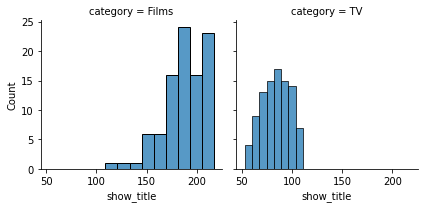

In [14]:
# Distribution of item count by country
items_by_country = df.groupby(['country_name', 'category']).nunique().show_title.reset_index()
facet_plot(items_by_country, 'show_title')

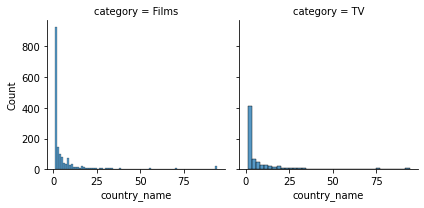

In [10]:
# Number of countries by item
countries_per_item = df.groupby(['category', 'item_title']).nunique().country_name.reset_index()
facet_plot(countries_per_item, 'country_name')

# U.S. TV stats

<AxesSubplot:>

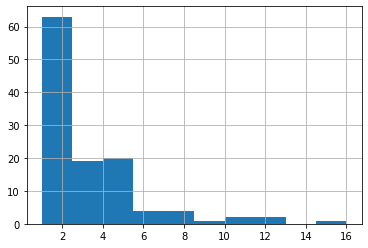

In [6]:
# Cumulative week distribution
df_filtered.groupby('item_title').cumulative_weeks_in_top_10.max().hist()

<AxesSubplot:xlabel='weekly_rank'>

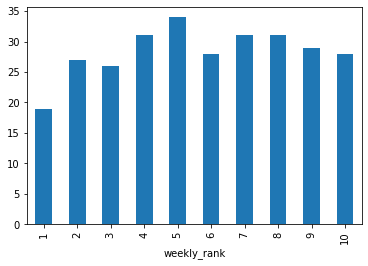

In [7]:
# Rank occupants
occupants = df_filtered.groupby('weekly_rank').item_title.nunique()
occupants.plot(kind='bar')

<AxesSubplot:xlabel='weekly_rank'>

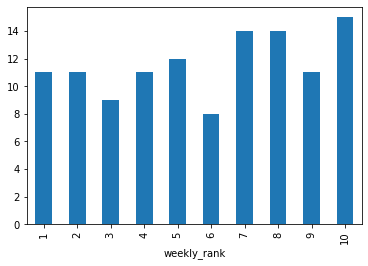

In [8]:
# First rank distribution
df_filtered[df_filtered.cumulative_weeks_in_top_10==1].groupby('weekly_rank').count().item_title.plot(kind='bar')

In [32]:
# Churn
weeks = df_filtered.sort_values(by='week').week.drop_duplicates().tolist()
weeks_pairs = list(zip(weeks, weeks[1:]))
churn = []
for w in weeks_pairs:
    turnover = len(set(df_filtered[df_filtered.week==w[0]].item_title) - set(df_filtered[df_filtered.week==w[1]].item_title))
    churn.append(turnover)
sum(churn) / len(churn)

3.3714285714285714

In [40]:
# Rank stickiness
df_filtered.groupby(['item_title', 'weekly_rank']).count().groupby(level=1).mean().week.plot(kind='bar')

,country_name,week,cumulative_weeks_in_top_10
weekly_rank,,,
1,1.894737,1.894737,1.894737
2,1.333333,1.333333,1.333333
3,1.384615,1.384615,1.384615
4,1.161290,1.161290,1.161290
5,1.058824,1.058824,1.058824
6,1.285714,1.285714,1.285714
7,1.161290,1.161290,1.161290
8,1.161290,1.161290,1.161290
9,1.241379,1.241379,1.241379


In [26]:
def concat(a):
    """Concatenates transition pairs for probability calculation"""
    return ' '.join(str(i) for i in a)

def check_for_zero(key):
    """Checks for zero in string key"""
    x,y = key.split(' ')
    return float(x)==0 or float(y)==0

def compare_ranks(r):
    if r['next_rank'] != r['next_rank']:
        return 'exit'

    if r['next_rank'] > r['weekly_rank']:
        return 'decrease'
    elif r['next_rank'] == r['weekly_rank']:
        return 'same'
    else:
        return 'increase'

<AxesSubplot:xlabel='transition', ylabel='weekly_rank'>

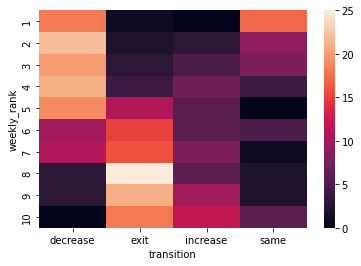

In [28]:
sample = df_filtered.sort_values(by=['item_title', 'week'])[['item_title', 'weekly_rank', 'week']]
sample['next_rank'] = sample.groupby('item_title').weekly_rank.shift(-1)
sample['transition'] = sample.apply(compare_ranks, axis=1)
counts = (sample.groupby(['weekly_rank', 'transition']).count().week.reset_index()\
    .pivot_table(index='weekly_rank', columns='transition', values='week')\
    .fillna(0))
sns.heatmap(counts)

<AxesSubplot:xlabel='end', ylabel='start'>

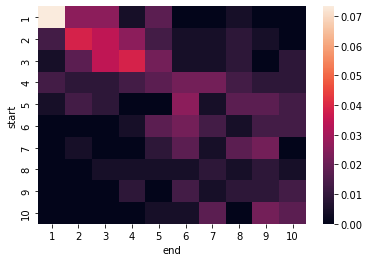

In [10]:
# Rank transition probabilities
sample = df_filtered.sort_values(by='week')[['item_title', 'weekly_rank', 'week']]
arr = pd.pivot(sample, index='item_title', columns='week', values='weekly_rank').fillna(0).to_numpy()
window_view = np.lib.stride_tricks.sliding_window_view(arr, 2, 1)
pairs = np.reshape(window_view, (window_view.shape[0] * window_view.shape[1], 2))
one_rank = pairs[~(pairs == 0).all(axis=1), :]
entries = (one_rank[:, 0]==0).sum() / one_rank.shape[0]
exits = (one_rank[:, 1]==0).sum() / one_rank.shape[0]
remains = (one_rank!=0).all(axis=1).sum() / one_rank.shape[0]
pairs = np.apply_along_axis(concat, 1, one_rank[(one_rank!=0).all(axis=1), :]).flatten()
pair_counts = Counter(pairs)
s = sum(pair_counts.values())
prob_dict = {k: v/s for k, v in pair_counts.items()}
prob_table = []
for k, v in prob_dict.items():
    start, end = k.split(' ')
    prob_table.append({"start": int(float(start)), "end": int(float(end)), "prob": v})
prob_table_df = pd.pivot(pd.DataFrame(prob_table), index='start', columns='end', values='prob').fillna(0)
sns.heatmap(prob_table_df)